In [1]:
from hydra import initialize, compose
from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, WeightedRandomSampler, random_split

from models import Vocabulary
from models.autoencoder import EncoderRNN, DecoderRNN, Autoencoder

In [2]:
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config", overrides=["+autoencoder=phone_word_frequency"])
    # cfg = compose(config_name="config", overrides=["+autoencoder=phone_word_uniform"])
cfg

{'trainer': {'batch_size': 32, 'checkpoint_path': 'autoencoder.pt'}, 'autoencoder': {'data': {'sampler': {'strategy': 'word', 'weights': 'unigram'}, 'representation': {'form': 'phone-sequence', 'drop_extras': True}}}}

In [3]:
%load_ext autoreload
%autoreload 2

## Prepare dataset

In [4]:
# "Extra" phones in TIMIT not corresponding to speech sounds
timit_extras = ["pau", "epi", "h#"]

In [5]:
df = pd.read_csv("timit_merged.csv")

In [6]:
if cfg.autoencoder.data.representation.drop_extras:
    df = df[~df.phone.isin(timit_extras)]

In [7]:
all_words = df.groupby(["dialect", "speaker", "sentence_idx", "word_idx"]).apply(lambda xs: xs.phone.str.cat(sep=" ")).value_counts()
all_words, all_word_freqs = [tuple(word.split(" ")) for word in all_words.index], list(all_words)

In [8]:
vocab = Vocabulary("")
for word in all_words:
    vocab.add_sequence(word)

In [9]:
# Prepare input tensor
max_length = 10
n = len(all_words)
input_ids = np.zeros((n, max_length), dtype=np.int32)
# target_ids = np.zeros((n, max_length), dtype=np.int32)

for idx, seq in enumerate(all_words):
    input_ids_i = [vocab.sos_token_id] + \
        [vocab.token2index[token] for token in seq][:max_length - 2] + \
        [vocab.eos_token_id]
    input_ids[idx, :len(input_ids_i)] = input_ids_i
    
all_data = TensorDataset(torch.LongTensor(input_ids), torch.LongTensor(all_word_freqs))
train_data, val_data, test_data = random_split(all_data, [0.8, 0.1, 0.1])

if cfg.autoencoder.data.sampler.strategy != "word":
    raise NotImplementedError()
if cfg.autoencoder.data.sampler.weights == "uniform":
    train_sampler = RandomSampler(train_data)
elif cfg.autoencoder.data.sampler.weights == "unigram":
    train_sampler = WeightedRandomSampler(
        train_data.dataset.tensors[1][train_data.indices], len(train_data.indices))

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=cfg.trainer.batch_size)
val_dataloader = DataLoader(val_data, batch_size=cfg.trainer.batch_size)

## Train

In [10]:
def train_epoch(dataloader, autoencoder, opt, criterion):
    total_loss = 0
    for data in dataloader:
        opt.zero_grad()
        
        batch_input, _ = data
        batch_target, _ = data
        
        dec_outputs, _ = autoencoder(batch_input, batch_target)
        
        loss = criterion(
            dec_outputs.view(-1, dec_outputs.size(-1)),
            batch_target.view(-1)
        )
        loss.backward()
        
        opt.step()
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [11]:
def evaluate(dataloader, autoencoder, criterion):
    with torch.no_grad():
        total_loss = 0
        decoded_sequences = []
        for data in dataloader:
            batch_input, _ = data
            batch_target, _ = data
            
            dec_outputs, _ = autoencoder(batch_input, batch_target)
            loss = criterion(
                dec_outputs.view(-1, dec_outputs.size(-1)),
                batch_target.view(-1)
            )
            total_loss += loss.item()

            _, topi = dec_outputs.topk(1, dim=-1)
            for seq in topi:
                decoded_tokens = []
                for idx in seq:
                    if idx == autoencoder.vocabulary.eos_token_id:
                        decoded_tokens.append("<EOS>")
                        break
                    decoded_tokens.append(autoencoder.vocabulary.index2token[idx.item()])

                decoded_sequences.append(decoded_tokens)
    
    total_loss /= len(val_dataloader)
    return total_loss, decoded_sequences

In [51]:
def train(train_dataloader, val_dataloader, autoencoder, n_epochs,
          learning_rate=1e-3, weight_decay=1e-4,
          print_every=100, val_every=100):
    print_loss_total = 0
    
    opt = optim.Adam(autoencoder.parameters(), lr=learning_rate,
                     weight_decay=weight_decay)
    criterion = nn.NLLLoss()
    
    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, autoencoder, opt, criterion)
        print_loss_total += loss
        
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("%d %.4f" % (epoch, print_loss_avg))
            
        if epoch % val_every == 0:
            val_loss, _ = evaluate(val_dataloader, autoencoder, criterion)
            print("--- val loss: %.4f" % val_loss)

In [52]:
hidden_size = 128
autoencoder = Autoencoder(hidden_size, vocab)

In [53]:
train(train_dataloader, val_dataloader, autoencoder, 20, print_every=1, val_every=1)

1 1.3538
--- val loss: 1.4104
2 0.5928
--- val loss: 0.9588
3 0.3603
--- val loss: 0.7197
4 0.2532
--- val loss: 0.5405
5 0.1958
--- val loss: 0.4562
6 0.1525
--- val loss: 0.3768
7 0.1282
--- val loss: 0.3286
8 0.1097
--- val loss: 0.3016
9 0.0937
--- val loss: 0.2604
10 0.0883
--- val loss: 0.2697
11 0.0788
--- val loss: 0.2273
12 0.0688
--- val loss: 0.2011
13 0.0614
--- val loss: 0.1934
14 0.0582
--- val loss: 0.1791
15 0.0518
--- val loss: 0.1928
16 0.0542
--- val loss: 0.1605
17 0.0484
--- val loss: 0.1576
18 0.0454
--- val loss: 0.1555
19 0.0434
--- val loss: 0.1441
20 0.0431
--- val loss: 0.1468


## Decode

In [54]:
val_loss, val_outputs = evaluate(val_dataloader, autoencoder, nn.NLLLoss())

In [55]:
val_loss

0.14652774213916725

In [56]:
val_inputs = [" ".join(autoencoder.vocabulary.index2token[idx.item()] for idx in seq.squeeze())
              for batch, _ in val_dataloader
              for seq in batch]

In [57]:
list(zip(val_inputs[:20], [" ".join(toks) for toks in val_outputs[:20]]))

[('<SOS> bcl b iy f ao r <EOS> <SOS> <SOS>', '<SOS> bcl b iy f ao r <EOS>'),
 ('<SOS> d ih s ax pcl p ih axr <EOS>', '<SOS> d ih s ax pcl p ih axr <EOS>'),
 ('<SOS> w ae gcl ix n <EOS> <SOS> <SOS> <SOS>', '<SOS> w ae gcl ix n <EOS>'),
 ('<SOS> dcl d ix v ao s <EOS> <SOS> <SOS>', '<SOS> dcl d ix v ao s <EOS>'),
 ('<SOS> t er m <EOS> <SOS> <SOS> <SOS> <SOS> <SOS>', '<SOS> t er m <EOS>'),
 ('<SOS> tcl t r ae l axr z <EOS> <SOS>', '<SOS> tcl t r ae l axr z <EOS>'),
 ('<SOS> bcl b ey s tcl t <EOS> <SOS> <SOS>', '<SOS> bcl b ey s tcl t <EOS>'),
 ('<SOS> ey ng sh ix n tcl t <EOS> <SOS>', '<SOS> ey sh sh ix n tcl t <EOS>'),
 ('<SOS> ae kcl k w iy eh s en <EOS>', '<SOS> ae kcl k s iy s s en <EOS>'),
 ('<SOS> m aa r sh m eh l ah <EOS>', '<SOS> m aa r sh m l l ah <EOS>'),
 ('<SOS> ao bcl er n <EOS> <SOS> <SOS> <SOS> <SOS>', '<SOS> ao bcl b n <EOS>'),
 ('<SOS> w ax th aw tcl <EOS> <SOS> <SOS> <SOS>',
  '<SOS> w ax th aw tcl <EOS>'),
 ('<SOS> ix q ae n tcl t ae gcl <EOS>', '<SOS> ix q ae n tcl t ae

## Checkpoint

In [58]:
torch.save(autoencoder, cfg.trainer.checkpoint_path)

## Plot

In [59]:
with torch.no_grad():
    val_encodings = []
    for data in val_dataloader:
        batch_inputs, _ = data
        batch_encodings, _ = autoencoder.encode(batch_inputs)
        val_encodings.append(batch_encodings.squeeze(0))

    val_encodings = torch.cat(val_encodings)
val_encodings.shape

torch.Size([1140, 128])

In [60]:
pca = PCA(2).fit(val_encodings)
val_encodings_pca = pca.transform(val_encodings)

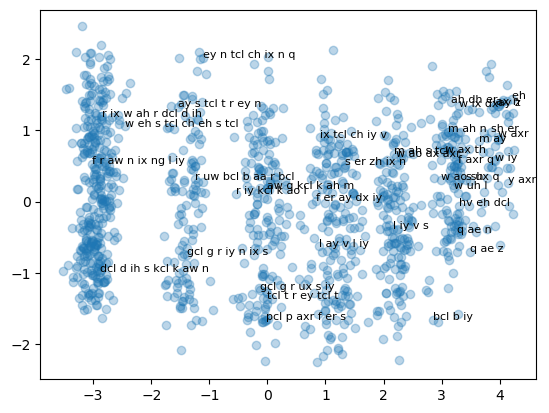

In [61]:
plt.scatter(val_encodings_pca[:, 0], val_encodings_pca[:, 1], alpha=0.3)

sample_ps = val_data.dataset.tensors[1][val_data.indices].float().numpy()
sample_ps /= sample_ps.sum()
for idx in np.random.choice(len(val_encodings_pca), size=40, replace=False,
                            p=sample_ps):
    input_i = val_inputs[idx]
    input_i = input_i[len("<SOS> "):]
    input_i = input_i[:input_i.index("<EOS>")]
    
    plt.text(val_encodings_pca[idx, 0], val_encodings_pca[idx, 1],
             input_i, fontdict={"fontsize": 8})

## Visualize distances

In [62]:
from scipy.spatial.distance import pdist, squareform

In [63]:
val_inputs_condensed = [input_str[len("<SOS> "):input_str.index("<EOS>")]
                        for input_str in val_inputs]

In [64]:
item_distances = squareform(pdist(val_encodings))
item_distances = pd.DataFrame(item_distances)
# Keep just the upper triangle, not including diagonal
item_distances = item_distances.where(np.triu(np.ones(item_distances.shape), k=1).astype(bool))
item_distances.index = val_inputs_condensed
item_distances.columns = val_inputs_condensed
item_distances = item_distances.stack().dropna()

In [65]:
len(val_inputs_condensed)

1140

In [66]:
item_distances.sort_values().head(10)

ix kcl k s pcl p l ih     ix kcl k s pcl p l ih        0.460153
ae l dcl jh ix bcl b r    ae l dcl jh ix bcl b r       0.563330
dcl d ix pcl p aa r tcl   dcl d ix pcl p aa r tcl      0.672634
ae m bcl b ih gcl y ux    ae m bcl b ih gcl g y        0.986636
ix n dcl jh ix n ih axr   ix n dcl jh ix n ih r        1.328681
eh kcl k s ax-h kcl k y   eh kcl k s ax-h kcl k ux     1.338260
n iy uw kcl k l ae s      n iy ow kcl k l ae s         1.393671
gcl g r iy n ix s         gcl g r iy s ix ng           1.510367
pcl p ey sh en tcl        pcl p ey sh en tcl t         1.521197
bcl b l ux s              bcl b l ux z                 1.523474
dtype: float64